# Data analysis of project for CS-A1155 - Databases for Data Science

### Group 14: Benjamin Herman, Quoc Quang Ngo, Thinh Nguyen

In [1]:
# import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import sqlalchemy
from datetime import date
import numpy as np
from scipy import stats


def conditional_commit():
    """Commit if major version number is greater than 1"""
    if int(sqlalchemy.__version__.split('.')[0]) > 1:
        psql_conn.commit()


in_script = False
cred_file = 'credentials.json'
# cred_file = 'credentials.json'
# use 'credentials.json' to connect to the remote database

# Load a dictionary of credentials
with open(cred_file) as fp:
    creds = json.load(fp)

db_url = 'postgresql+psycopg2://' + \
    '{user}:{password}@{host}:{port}/{database}'. \
    format(**creds)

engine = create_engine(db_url)


### Data analysis

In this part, we further examined the analyses done in question 4,5 and 6 of project part 3 by visualizing the output data.

In [2]:
## Add a new column 'agrGroup' to patient df 
with engine.connect() as psql_conn:
    patients_df = pd.read_sql_table('patients', psql_conn)
    print(patients_df['dateofbirth'].dtypes)
    today = date.today()
    patients_df['age'] = patients_df['dateofbirth'].apply(
        lambda x: today.year - x.year - 
        ((today.month, today.day) < (x.month, x.day)))
    
    bins= [0,10,20,40,60,200]
    labels = ['0-10','10-20','20-40','40-60','60+']
    patients_df['ageGroup'] = pd.cut(patients_df['age'], bins=bins,
                                     labels=labels, right=False)
    patients_df = patients_df.drop(columns=['age'])
    print(patients_df)
    

datetime64[ns]
            ssno                   name dateofbirth gender ageGroup
0    841229-112N       Rodolfo O'Reilly  1984-12-29      M    20-40
1    780214-1893  Prof. Erling Morar MD  1978-02-14      F    40-60
2    950303-191X  Dr. Simeon Keeling II  1995-03-03      M    20-40
3    730218-253D            Dereck Beer  1973-02-18      M    40-60
4    971214-2818   Prof. Brice Metz PhD  1997-12-14      M    20-40
..           ...                    ...         ...    ...      ...
145  881210-971J        Brain Greenholt  1988-12-10      M    20-40
146  110614-978B      Ms. Hanna Corkery  2011-06-14      F    10-20
147  830908-9826               Ana Ward  1983-09-08      F    20-40
148  080305-985A             Ricky Kuhn  2008-03-05      M    10-20
149  011119-9865          Ahmad Kovacek  2001-11-19      M    20-40

[150 rows x 5 columns]


In [3]:
# Add a new column 'vaccinationStatus'. 
# The value '0' represents 'not vaccinated', '1' for 'vaccinated once', and '2' for 'fully-vaccinated'.
with engine.connect() as psql_conn:
    statement = '''
    -- the number of vaccines a patient has had so far
    SELECT DISTINCT p.ssno As patientSsNo, COUNT(*) AS vaccinationstatus
    FROM patients p
    JOIN vaccinepatients vp ON p.ssno = vp.patientssno
    GROUP BY p.ssno;
        '''
    result = psql_conn.execute(text(statement))
    out = result.fetchall()
    column_names = list(result.keys())
    df = pd.DataFrame.from_records(out, columns=column_names)
    output_string = df.to_string(index=False)
    
    merged_df = pd.merge(patients_df, df, left_on='ssno',
                         right_on='patientssno',
                         how='left').drop('patientssno', axis=1)
    merged_df['vaccinationstatus'] = merged_df['vaccinationstatus'] \
        .fillna(0).astype('int64')
    merged_df.rename({'vaccinationstatus': 'vaccinationStatus'},
                     axis=1, inplace=True)
    print(merged_df)
    

            ssno                   name dateofbirth gender ageGroup  \
0    841229-112N       Rodolfo O'Reilly  1984-12-29      M    20-40   
1    780214-1893  Prof. Erling Morar MD  1978-02-14      F    40-60   
2    950303-191X  Dr. Simeon Keeling II  1995-03-03      M    20-40   
3    730218-253D            Dereck Beer  1973-02-18      M    40-60   
4    971214-2818   Prof. Brice Metz PhD  1997-12-14      M    20-40   
..           ...                    ...         ...    ...      ...   
145  881210-971J        Brain Greenholt  1988-12-10      M    20-40   
146  110614-978B      Ms. Hanna Corkery  2011-06-14      F    10-20   
147  830908-9826               Ana Ward  1983-09-08      F    20-40   
148  080305-985A             Ricky Kuhn  2008-03-05      M    10-20   
149  011119-9865          Ahmad Kovacek  2001-11-19      M    20-40   

     vaccinationStatus  
0                    2  
1                    1  
2                    1  
3                    1  
4                    1

In [4]:
# A spreadsheet-style pivot table as a dataFrame is created and shows the percentage of patients 
# who have received zero, one, or two doses of vaccines by age group.

with engine.connect() as psql_conn:
    pivot_df = pd.pivot_table(merged_df, index='vaccinationStatus', 
                         values='ssno', 
                         columns='ageGroup',
                         aggfunc='count')
    
    pivot_df['0-10'] = round((pivot_df['0-10']/pivot_df['0-10'].sum())*100, 2). \
                       fillna(0).astype(str) + '%'
    pivot_df['10-20'] = round((pivot_df['10-20']/pivot_df['10-20'].sum())*100, 2). \
                        fillna(0).astype(str) + '%'
    pivot_df['20-40'] = round((pivot_df['20-40']/pivot_df['20-40'].sum())*100, 2). \
                        fillna(0).astype(str) + '%'
    pivot_df['40-60'] = round((pivot_df['40-60']/pivot_df['40-60'].sum())*100, 2). \
                        fillna(0).astype(str) + '%'
    pivot_df['60+'] = round((pivot_df['60+']/pivot_df['60+'].sum())*100, 2). \
                      fillna(0).astype(str) + '%'
    print(pivot_df)

ageGroup             0-10   10-20   20-40  40-60   60+
vaccinationStatus                                     
0                  57.14%  35.14%  32.69%  52.5%  0.0%
1                  33.33%  56.76%  55.77%  45.0%  0.0%
2                   9.52%   8.11%  11.54%   2.5%  0.0%


#### Question 1: How does the vaccination progress look like for each age group compared to its total age group population?

ageGroup            0-10  10-20  20-40  40-60  60+
vaccinationStatus                                 
0                  57.14  35.14  32.69   52.5  0.0
1                  33.33  56.76  55.77   45.0  0.0
2                   9.52   8.11  11.54    2.5  0.0


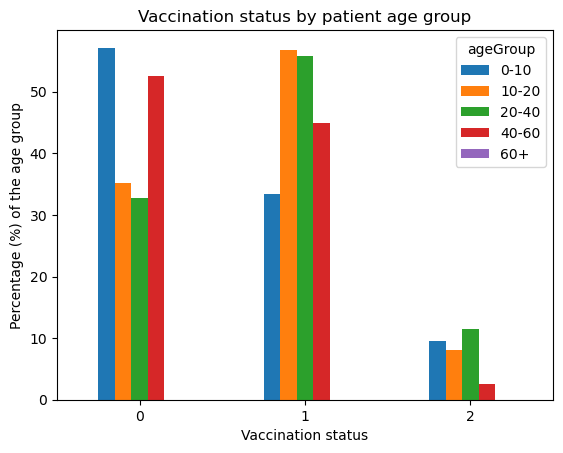

In [5]:
with engine.connect() as psql_conn:
    df = pd.pivot_table(merged_df, index='vaccinationStatus', 
                         values='ssno', 
                         columns='ageGroup',
                         aggfunc='count')
    
    df['0-10'] = round((df['0-10']/df['0-10'].sum())*100, 2). \
                       fillna(0)
    df['10-20'] = round((df['10-20']/df['10-20'].sum())*100, 2). \
                        fillna(0)
    df['20-40'] = round((df['20-40']/df['20-40'].sum())*100, 2). \
                        fillna(0)
    df['40-60'] = round((df['40-60']/df['40-60'].sum())*100, 2). \
                        fillna(0)
    df['60+'] = round((df['60+']/df['60+'].sum())*100, 2). \
                      fillna(0)
    
    print(df)
    
    df.plot(kind='bar')
    plt.title('Vaccination status by patient age group')
    plt.xlabel('Vaccination status')
    plt.xticks(rotation = 0)
    plt.ylabel('Percentage (%) of the age group')

The plot above illustrates the vaccination status in percentage of each patient age group compared to its group population. 

It is clear that there were no patients over 60 years old and the vaccination progress was not equal among age groups. Most children between 0 and 10 years old were either not vaccinated or vaccinated once with over 50% and one third of the total group size respectively. Similarly, slightly over half of the age group 40-60 did not receive any Corona vaccination, but the percentage of those who got vaccinated once was higher than the previously mentioned group by almost 12%. Groups of 10-20 youngsters and 20-40 people both show a higher percentage in the vaccinated once status with over 50%, followed by non-vaccinated status with approximately 33-35% of the total group population. In addition, the plot shows that the number of patients in each age group getting vaccinated twice was very small, compared to the total age group size. 

#### Question 2: How does the vaccination progress look like for each age group compared to the total sample population?

ageGroup           0-10  10-20  20-40  40-60  60+
vaccinationStatus                                
0                  8.00   8.67  11.33  14.00  0.0
1                  4.67  14.00  19.33  12.00  0.0
2                  1.33   2.00   4.00   0.67  0.0


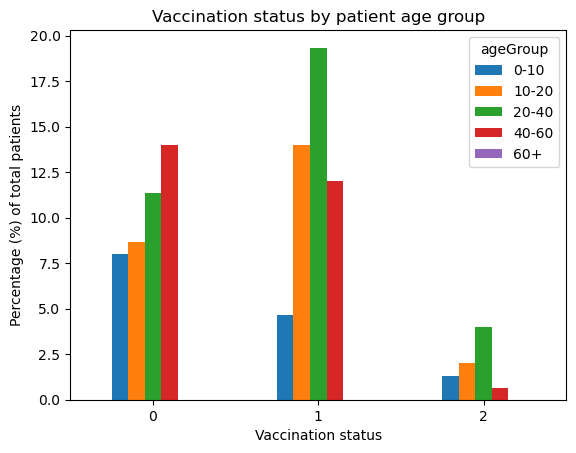

In [6]:
with engine.connect() as psql_conn:
    df2 = pd.pivot_table(merged_df, index='vaccinationStatus', 
                         values='ssno', 
                         columns='ageGroup',
                         aggfunc='count')

    df2['0-10'] = round((df2['0-10']/len(merged_df))*100, 2). \
                       fillna(0)
    df2['10-20'] = round((df2['10-20']/len(merged_df))*100, 2). \
                        fillna(0)
    df2['20-40'] = round((df2['20-40']/len(merged_df))*100, 2). \
                        fillna(0)
    df2['40-60'] = round((df2['40-60']/len(merged_df))*100, 2). \
                        fillna(0)
    df2['60+'] = round((df2['60+']/len(merged_df))*100, 2). \
                      fillna(0)
    
    print(df2)
    df2.plot(kind='bar')
    plt.title('Vaccination status by patient age group')
    plt.xlabel('Vaccination status')
    plt.xticks(rotation = 0)
    plt.ylabel('Percentage (%) of total patients')

The plot above presents the vaccination status in percentage of each patient age group compared to the total population. According to this data visualization, there were no patients over 60 years old and the vaccination progress was not equal among age groups. 

In general, the majority of the population were either not vaccinated or vaccinated once with 92% in total. The highest percentage is found in the age group 20-40 with the vaccinated once status, followed by the age group 40-60 with the vaccinated once status and the age group 10-20 who did not get vaccinated. It can be also noted that the number of fully vaccinated people accounts for a very small portion in each age group. The highest portion can be seen in the age group 20-40 with 4% of the whole population. 

#### Question 3: How does the vaccination progress look like for each gender and each age group?

ageGroup                  0-10  10-20  20-40  40-60  60+
gender vaccinationStatus                                
F      0                     7      7      5     10    0
       1                     3     17     11      9    0
       2                     2      0      1      1    0
M      0                     5      6     12     11    0
       1                     4      4     18      9    0
       2                     0      3      5      0    0


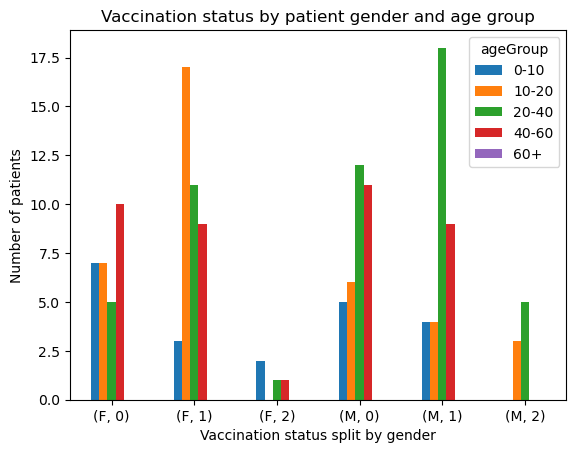

In [7]:
with engine.connect() as psql_conn:
    df3 = pd.pivot_table(merged_df, index=['gender', 'vaccinationStatus'], 
                         values='ssno', 
                         columns='ageGroup',
                         aggfunc='count')
    print(df3)
    
    df3.plot(kind='bar')
    plt.title('Vaccination status by patient gender and age group')
    plt.xlabel('Vaccination status split by gender')
    plt.xticks(rotation = 0)
    plt.ylabel('Number of patients')

The plot above shows the vaccination status of each age group and patient gender. It is evident from this visualization that the vaccination progress varies among age groups and genders, even though both genders constitute an almost equal portion of the population. 17 female patients got vaccinated once and aged between 10 and 20, making this segment the largest in the female group followed by those with the same vaccination status but aged 20-40. In their counterpart group, the biggest group includes male patients between 20 and 40 with the vaccinated once status, followed by those in the same age group by not getting vaccinated yet.

#### Question 4: Are symptom reports affected by vaccine type

This analysis uses the results of questions 1 and 2 of part 3 of the project, so we repeat the code from there, although this could be run without it as long as the database is still in place as modified by the code.

In [8]:
with engine.connect() as psql_conn:
    # 1.
    diagnoses = pd.read_sql_table('diagnosis', psql_conn)
    diagnoses.rename({'patient': 'ssno', 'reportdate': 'diagnosisdate'},
                     axis=1, inplace=True)

    patients = pd.read_sql_table('patients', psql_conn)
    patients.drop('name', axis=1, inplace=True)

    patientsymptoms = pd.merge(patients, diagnoses,
                               on='ssno', how='right')

    patientsymptoms = patientsymptoms[['ssno', 'gender', 'dateofbirth',
                                       'symptom', 'diagnosisdate']]

    patientsymptoms.to_sql('patientsymptoms', psql_conn,
                           if_exists='replace', index=True)

    conditional_commit()


In [9]:
with engine.connect() as psql_conn:
    # 2.
    vaccpats = pd.read_sql_table('vaccinepatients', psql_conn)
    vaccinations = pd.read_sql_table('vaccinations', psql_conn)
    batches = pd.read_sql_table('vaccinebatch', psql_conn)

    batches.drop(['numvaccines', 'manufacturer', 'dateproduced',
                  'expirationdate', 'location'],
                 axis=1, inplace=True)

    vaccpats = pd.merge(vaccpats, vaccinations,
                        on=('vaccinationdate', 'location'),
                        how='left')

    vaccpats = pd.merge(vaccpats, batches,
                        on='batchid',
                        how='left')

    vaccpats.sort_values(by='vaccinationdate', inplace=True)

    vaccpats.rename({'patientssno': 'ssno'}, inplace=True, axis=1)

    nulls = [None] * patients.shape[0]
    pvi = pd.concat([patients.ssno,
                    pd.DataFrame({'date1': nulls,
                                  'vaccinetype1': nulls,
                                  'date2': nulls,
                                  'vaccinetype2': nulls})],
                    axis=1)

    pvi.set_index('ssno', inplace=True)
    for _, row in vaccpats.iterrows():
        if pvi.isna().loc[row.ssno, 'date1']:
            pvi.loc[row.ssno, 'date1'] = row.vaccinationdate
            pvi.loc[row.ssno, 'vaccinetype1'] = row.vaccineid
        elif pvi.isna().loc[row.ssno, 'date2']:
            pvi.loc[row.ssno, 'date2'] = row.vaccinationdate
            pvi.loc[row.ssno, 'vaccinetype2'] = row.vaccineid
        else:
            raise Exception('Third vaccination found')

    pvi.reset_index(inplace=True)
    pvi.to_sql('patientvaccineinfo', psql_conn,
               if_exists='replace', index=True)

    conditional_commit()


We are interested in whether there is a difference in the tendency of vaccines to cause symptoms depending on which type of vaccine is given.  We look at data of information about what vaccines patients have received and what symptoms were reported.

In [10]:
with engine.connect() as psql_conn:
    pvi = pd.read_sql_table('patientvaccineinfo', psql_conn)
    diagnoses = pd.read_sql_table('patientsymptoms', psql_conn)

We take diagnoses only where they occur on or after the initial vaccination date

In [11]:
diag_and_vac_info = pd.merge(diagnoses, pvi, on='ssno', how='left')
diag_and_vac_info = diag_and_vac_info[
    pd.to_datetime(diag_and_vac_info.diagnosisdate)
    >= pd.to_datetime(diag_and_vac_info.date1)]

Examining the patient vaccine info where patients have received two doses:

In [12]:
pvi[pvi.vaccinetype2.notna()]

,index,ssno,date1,vaccinetype1,date2,vaccinetype2
0,0,841229-112N,2021-01-30,V01,2021-02-14,V03
11,11,890104-753F,2021-01-30,V01,2021-02-14,V03
15,15,840805-1135,2021-01-30,V01,2021-02-14,V03
40,40,751211-287B,2021-01-30,V01,2021-02-14,V03
44,44,060421-302M,2021-03-16,V01,2021-05-10,V02
52,52,880810-358W,2021-01-30,V03,2021-02-14,V03
60,60,090416-443L,2021-03-16,V01,2021-05-10,V02
66,66,871128-519R,2021-03-16,V01,2021-05-10,V02
68,68,010327-525G,2021-03-16,V01,2021-05-10,V02
74,74,090226-5673,2021-03-16,V01,2021-05-10,V02


We see that there are only 12 patients that have received two doses, and usually they are of different types.  So we only look at patients who received a first and only a first dose and compute the number of symptoms that were reported for each patient.

In [13]:

# take only rows where patient did not receive a second dose
pvi = pvi[pvi.date2.isna()]

# remove rows where patient did not receive a first dose
pvi = pvi.dropna(subset=['date1'])[['ssno', 'date1', 'vaccinetype1']]


In [14]:
# get counts of diagnoses for each patient
grps = diag_and_vac_info.groupby('ssno')
counts = grps.count().rename({'index_x': 'count_'}, axis=1) \
    .reset_index()[['ssno', 'count_']]

type_counts = pd.merge(pvi, counts, on='ssno', how='left')

type_counts['count_'] = type_counts.count_.fillna(0)


We take a look at the data.

In [15]:
type_counts

,ssno,date1,vaccinetype1,count_
0,780214-1893,2021-01-30,V01,1.0
1,950303-191X,2021-02-14,V03,2.0
2,730218-253D,2021-03-16,V01,3.0
3,971214-2818,2021-02-14,V03,1.0
4,060325-323X,2021-01-30,V03,4.0
...,...,...,...,...
70,850310-787I,2021-05-10,V01,3.0
71,090602-7898,2021-05-10,V02,0.0
72,041113-8113,2021-05-10,V02,1.0
73,090518-869W,2021-05-10,V02,1.0


In [16]:
type_counts.vaccinetype1.value_counts()

V03    30
V01    24
V02    21
Name: vaccinetype1, dtype: int64

We would like to use scipy.stats's f_oneway function to perform an ANOVA analysis.  This requires that variances are equal and that either data is normally distributed or there are a lot of data points.  Clearly there are not many data points, so we look to see if the data might be approximately normally distributed by looking at histograms.

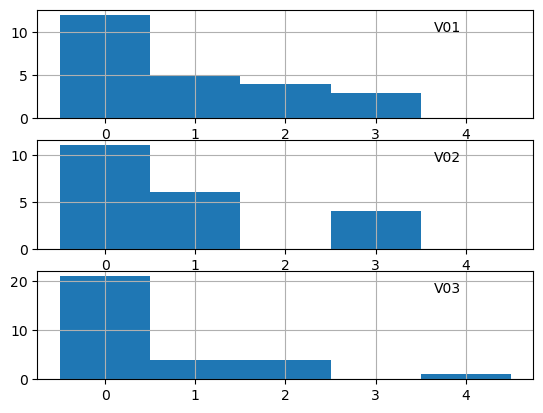

In [17]:
counts_v01 = type_counts.count_[type_counts.vaccinetype1 == 'V01']
counts_v02 = type_counts.count_[type_counts.vaccinetype1 == 'V02']
counts_v03 = type_counts.count_[type_counts.vaccinetype1 == 'V03']


def add_text_axis_coord(ax, x, y, s, **kwargs):
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    xd = x1 + (x2 - x1)*x
    yd = y1 + (y2 - y1)*y
    return ax.text(xd, yd, s, **kwargs)


fig, axes = plt.subplots(3, 1)
labels = ['V01', 'V02', 'V03']

bins = np.linspace(-0.5, 4.5, 6)

_ = counts_v01.hist(ax=axes[0], bins=bins)
_ = counts_v02.hist(ax=axes[1], bins=bins)
_ = counts_v03.hist(ax=axes[2], bins=bins)

for ax, lab in zip(axes, labels):
    _ = add_text_axis_coord(ax, 0.8, 0.8, lab)


It looks like there might be a difference in the effects between V03 and the other data. However, obviously these data are not normally distributed, so we must abandon our original approach.   Instead, we convert our data to binary, where 1 represents the case where the number of symptom reports is greater than zero, and 0 represents no symptoms being reported.  We then perform pairwise comparisons using the two-sample proportion test, where for any pair of samples, the null hypothesis is that probabilities of a 1 occurring are equal.  Since the probability for at least one type I error among the three combinations is increased, we must adjust the required p-value to be one third of the prescribed significance level, which we chose to be 0.05 as is typically done.  That is, we apply the Bonferroni correction and look for p-values less than 0.01667.

In [18]:
def two_sample_proportion_test(X, Y):
    """
    Returns the p-value from a two-sample proportion test.
    This is based on lecture slides from the course:
    MS-C1620 Statistical Inference at Aalto University in Spring 2023
    taught by Jukka Kohonen.
    :param X: One sample of binary data
    :param Y: Another sample of binary data
    :return: p-value
    """
    assert X.apply(lambda u: u in {0, 1}).all()
    assert Y.apply(lambda u: u in {0, 1}).all()
    n = len(X)
    m = len(Y)
    sx = X.sum()
    sy = Y.sum()

    theta_x = sx/n
    theta_y = sy/m

    theta = (sx + sy) / (n + m)

    Z = (theta_x - theta_y) \
        / np.sqrt(theta * (1 - theta) * (1 / n + 1 / m))

    warning_message = 'Results are not statistically accurate'
    if n * theta_x <= 5:
        print(f'Warning n * theta_hat_x <= 5.  {warning_message}')
    if n * (1 - theta_x) <= 5:
        print(f'Warning n * (1 - theta_hat_x) <= 5.  {warning_message}')
    if m * theta_y <= 5:
        print(f'Warning m * theta_hat_y <= 5.  {warning_message}')
    if m * (1 - theta_y) <= 5:
        print(f'Warning m * (1 - theta_hat_y) <= 5.  {warning_message}')

    p = 2 * stats.norm().cdf(-np.abs(Z))
    return p

p = two_sample_proportion_test(1 * (counts_v03 > 0),
                               1 * (counts_v02 > 0))

print(f'p-value = {p}')

p = two_sample_proportion_test(1 * (counts_v03 > 0),
                               1 * (counts_v01 > 0))

print(f'p-value = {p}')

p = two_sample_proportion_test(1 * (counts_v02 > 0),
                               1 * (counts_v01 > 0))

print(f'p-value = {p}')

p-value = 0.2002590712500678
p-value = 0.13412008326379768
p-value = 0.873351235048516


While it did look like there might be a difference of symptoms depending on vaccine type, there is not enough evidence to rule out that this might have occurred by chance.